In [1]:
import pandas as pd 
import os 
import pathlib 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

path_to_main_output = "/media/hieunguyen/HNHD01/outdir/ampliconSeq/new/data_analysis"
path_to_02_output = os.path.join(path_to_main_output, "02_output")
os.system(f"mkdir -p {path_to_02_output}")

maindir = "/media/hieunguyen/HNHD01/outdir/ampliconSeq/from_VM/UMI_FROM_R1_ONLY"

all_umi_files = [item for item in pathlib.Path(maindir).glob("*.txt")]

all_potential_umis = [f"{a}{s}{d}{f}{g}{h}" for a in "ACGT" for s in "ACGT" for d in "ACGT" for f in "ACGT" for g in "ACGT" for h in "ACGT"]

umidf = pd.DataFrame(all_potential_umis, columns=["umi"])
umi_pct_df = pd.DataFrame(all_potential_umis, columns=["umi"])
entropydf = pd.DataFrame()
rerun = True
if os.path.isfile(os.path.join(path_to_02_output, "all_umis.txt")) == False or rerun == True:
    for file in tqdm(all_umi_files):
        sampleid = file.name.replace(".UMI.txt", "")
        if sampleid != "45-TMS7E_S7545-S7745":
            tmpdf = pd.read_csv(file, sep="\t", header=None, names=["umi"])
            tmpdf = tmpdf[tmpdf["umi"].str.contains("N") == False]
            tmpdf = tmpdf.reset_index().groupby("umi")["index"].count().reset_index()
            tmpdf.columns = ["umi", sampleid]
            tmpdf[sampleid] = tmpdf[sampleid].astype(int)
            tmpdf[f"pct_{sampleid}"] = tmpdf[sampleid].apply(lambda x: 100 * x / tmpdf[sampleid].sum())
            shannon_entropy = -np.sum([item * np.log2(item) for item in tmpdf[f"pct_{sampleid}"].values if item > 0])/len(all_potential_umis)
            umidf = umidf.merge(tmpdf[["umi", sampleid]], right_on = "umi", left_on= "umi", how="left")
            umi_pct_df = umi_pct_df.merge(tmpdf[["umi", f"pct_{sampleid}"]], right_on = "umi", left_on= "umi", how="left")
            tmp_entropydf = pd.DataFrame({"sampleid": [sampleid], "shannon_entropy": [shannon_entropy]})
            entropydf = pd.concat([entropydf, tmp_entropydf], ignore_index=True)
    umidf = umidf.fillna(0)
    umi_pct_df = umi_pct_df.fillna(0)

    umidf.to_csv(os.path.join(path_to_02_output, "all_umis.txt"), sep="\t", index=False)
    umi_pct_df.to_csv(os.path.join(path_to_02_output, "all_umis_pct.txt"), sep="\t", index=False)
    entropydf.to_csv(os.path.join(path_to_02_output, "umi_entropy.txt"), sep="\t", index=False)
else:
    umidf = pd.read_csv(os.path.join(path_to_02_output, "all_umis.txt"), sep="\t")
    umi_pct_df = pd.read_csv(os.path.join(path_to_02_output, "all_umis_pct.txt"), sep="\t")
    entropydf = pd.read_csv(os.path.join(path_to_02_output, "umi_entropy.txt"), sep="\t")


100%|██████████| 110/110 [01:08<00:00,  1.60it/s]


(0.0, 1.0)

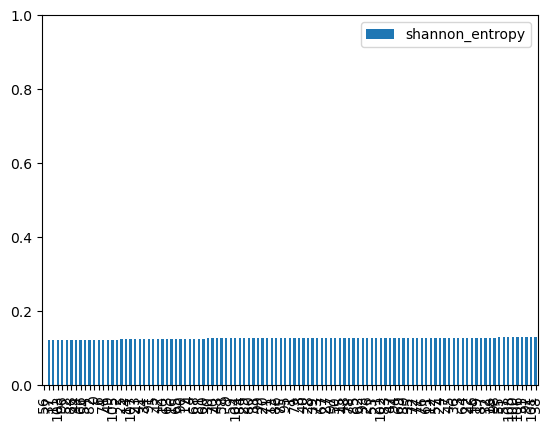

In [2]:
entropydf.sort_values(by="shannon_entropy", ascending=True, inplace=True)
entropydf.plot.bar()
plt.ylim([0, 1])


In [3]:
count_max_df = pd.DataFrame()
for sampleid in umidf.columns[1:]:
    max_umi = umidf[umidf[sampleid] == umidf[sampleid].max()]["umi"].values[0]
    top5_umi = umidf.sort_values(by=sampleid, ascending=False).head(5)
    tmpcount_max_df = pd.DataFrame({"sampleid": [sampleid], 
                                    "max_umi": [max_umi], 
                                    "max_5_umi": ",".join(sorted(top5_umi["umi"].to_list())),
                                    "max_count": [umidf[sampleid].max()],
                                    "max_pct": [umi_pct_df[f"pct_{sampleid}"].max()]})
    count_max_df = pd.concat([count_max_df, tmpcount_max_df], ignore_index=True)
count_max_df.groupby("max_umi")["sampleid"].count().sort_values(ascending=False)


max_umi
TTTTTT    56
CCCCCC    20
CCACCC     4
CTTTTT     4
CCGACC     4
CCCCGC     3
CTCCCC     3
CCCTCC     3
TGTTTT     2
AATCCC     1
AAAAAA     1
CTAGGA     1
CTAGCT     1
CGTTTT     1
CGATCT     1
TCCATC     1
GTTTGC     1
TCCGTC     1
TTCTTT     1
Name: sampleid, dtype: int64

In [4]:
count_max_df.groupby("max_5_umi")["sampleid"].count().sort_values(ascending=False).reset_index()

,max_5_umi,sampleid
0,"CCCCCC,CCCCTC,CCCTCC,CTCCCC,TCCCCC",5
1,"TCTTTT,TTCTTT,TTTCTT,TTTTTC,TTTTTT",5
2,"CCTCCC,CCTCCT,CCTCTC,CCTTCC,TTTTTT",4
3,"ATTTTT,TATTTT,TTTTTA,TTTTTC,TTTTTT",3
4,"ATTTTT,CTTTTT,TCTTTT,TTCTTT,TTTTTT",3
...,...,...
78,"TACTTT,TCTTTT,TTCATT,TTCTTT,TTTTTT",1
79,"TATTTT,TCTTTT,TTATTT,TTCTTT,TTTTTT",1
80,"TATTTT,TTTTCT,TTTTTA,TTTTTC,TTTTTT",1
81,"TCTTTT,TTCTTT,TTTTCT,TTTTTC,TTTTTT",1


In [5]:
checkdf = umidf[["umi", "34-TML10S4_S7534-S7734"]].sort_values(by="34-TML10S4_S7534-S7734", ascending=False)
checkdf[checkdf["umi"] == "CTTGGC"]

,umi,34-TML10S4_S7534-S7734
2025,CTTGGC,42


In [6]:
checkdf

,umi,34-TML10S4_S7534-S7734
4095,TTTTTT,565
3903,TTATTT,401
3967,TTCTTT,382
3327,TATTTT,314
3583,TCTTTT,284
...,...,...
335,ACCATT,8
1107,CACCAT,5
2131,GACCAT,4
3155,TACCAT,4


In [7]:
tmpdf = umidf[["umi", sampleid]].sort_values(by=sampleid, ascending=True)
tmpdf["accumsum"] = tmpdf[sampleid].cumsum()

In [8]:
from itertools import combinations

def hamming_distance(s1, s2):
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

umi_counts = dict(zip(tmpdf['umi'], tmpdf[sampleid]))

merged = set()
new_umi_counts = {}

for umi in tmpdf['umi']:
    if umi in merged:
        continue
    # Find UMIs with hamming distance <= 1
    similar = [umi2 for umi2 in tmpdf['umi'] if umi2 != umi and hamming_distance(umi, umi2) <= 1]
    total_count = umi_counts[umi]
    for umi2 in similar:
        if umi2 not in merged:
            total_count += umi_counts[umi2]
            merged.add(umi2)
    new_umi_counts[umi] = total_count
    merged.add(umi)

combined_UMI = pd.DataFrame(list(new_umi_counts.items()), columns=['umi', sampleid]).sort_values(sampleid, ascending=False).reset_index(drop=True)

In [9]:
combined_UMI

,umi,30-TML9S5_S7530-S7730
0,TCGTGT,7949
1,AACCCC,6172
2,GTCGTG,5903
3,CGTGTA,5881
4,TAGCTT,5806
...,...,...
706,ACTGAT,520
707,CCCGGA,518
708,ATCAAC,476
709,AGGGGC,412
